MNIST手写数字识别系统初始化...
✓ 找到模型文件: simple_resnet_mnist_stepLR.pth
使用设备: cpu
✓ 模型已从 'simple_resnet_mnist_stepLR.pth' 加载
✓ 识别器已创建


C:\Users\oldhare\AppData\Local\Temp\ipykernel_31276\3487786379.py:185: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\oldhare\AppData\Local\Temp\ipykernel_31276\3487786379.py:185: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\oldhare\AppData\Local\Temp\ipykernel_31276\3487786379.py:185: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\oldhare\AppData\Local\Temp\ipykernel_31276\3487786379.py:185: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\oldhare\AppData\Local\Temp\ipykernel_31276\3487786379.py:185: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\oldhare\AppData\Local\Temp\ipykernel_31276\3487786379.py:185: UserWarni

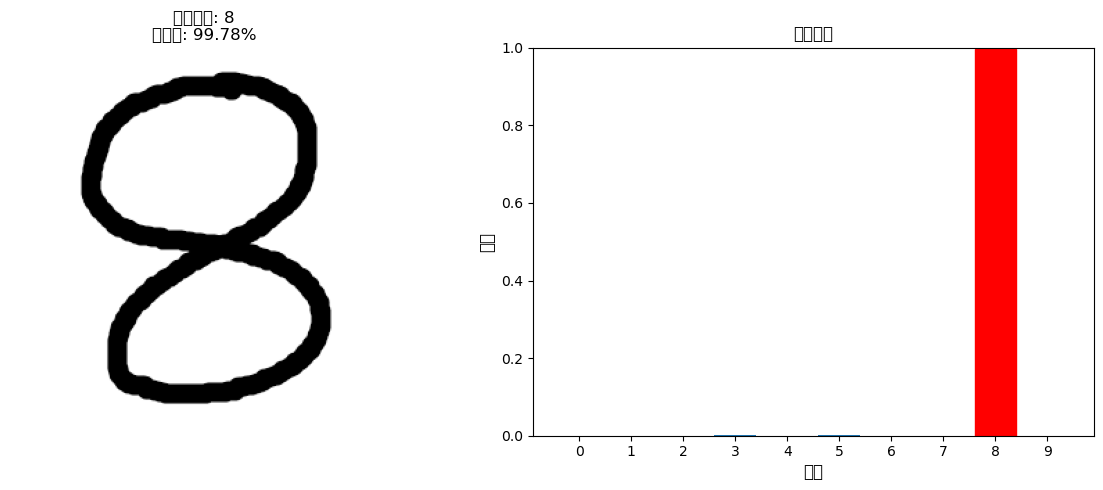


预测结果: 数字 8
置信度: 99.78%


In [19]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import json

# ==================== 1. 模型定义 ====================
class SimpleResBlock(nn.Module):
    """简化的残差块"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        identity = x
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return torch.nn.functional.relu(out)

class SimpleResNet(nn.Module):
    """简化的ResNet模型"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.resblock1 = SimpleResBlock(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.resblock2 = SimpleResBlock(32)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ==================== 2. 简化的图片预处理函数 ====================
def preprocess_image(image_path):
    """
    预处理手写数字图片，使其符合MNIST格式
    
    参数:
        image_path: 图片路径
    
    返回:
        tensor_img: 预处理后的PyTorch Tensor，形状为(1, 1, 28, 28)
    """
    # 1. 读取图片
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"无法读取图片: {image_path}")
    
    # 2. 调整大小到28x28
    img = cv2.resize(img, (28, 28))
    
    # 3. 自动判断是否需要反色
    # MNIST数据集是白底黑字，但用户可能提供黑底白字
    mean_val = np.mean(img)
    if mean_val > 127:  # 如果图片较亮，可能是白底黑字
        img = 255 - img  # 反色处理
    
    # 4. 归一化到0-1范围
    img = img.astype(np.float32) / 255.0
    
    # 5. 转换为Tensor并添加维度
    tensor_img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # (1, 1, 28, 28)
    
    # 应用与训练时相同的归一化
    normalize_transform = transforms.Normalize((0.1307,), (0.3081,))
    tensor_img = normalize_transform(tensor_img)
    
    return tensor_img

# ==================== 3. 简化的模型加载和预测 ====================
class MNISTDigitRecognizer:
    """MNIST手写数字识别器"""
    
    def __init__(self, model_path='simple_resnet_mnist_stepLR.pth', device=None):
        # 设置设备
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        
        print(f"使用设备: {self.device}")
        
        # 检查模型文件是否存在
        if not os.path.exists(model_path):
            print(f"警告: 模型文件 '{model_path}' 不存在")
            print("请确保模型文件存在，或使用正确的路径")
            print("当前工作目录:", os.getcwd())
            return
        
        # 加载模型
        self.model = SimpleResNet().to(self.device)
        try:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.eval()  # 设置为评估模式
            print(f"✓ 模型已从 '{model_path}' 加载")
        except Exception as e:
            print(f"× 加载模型失败: {e}")
            raise
    
    def predict(self, image_path, show_probabilities=True, show_image=True):
        try:
            # 检查图片是否存在
            if not os.path.exists(image_path):
                print(f"错误: 文件 '{image_path}' 不存在")
                return None, None, None
            
            # 1. 预处理图片
            input_tensor = preprocess_image(image_path)
            input_tensor = input_tensor.to(self.device)
            
            # 2. 进行预测
            with torch.no_grad():
                output = self.model(input_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                predicted = torch.argmax(probabilities, dim=1)
                confidence = torch.max(probabilities).item()
            
            # 转换为numpy数组
            probabilities_np = probabilities.cpu().numpy()[0]
            predicted_digit = predicted.item()
            
            # 3. 显示结果
            if show_image:
                self._display_result(image_path, predicted_digit, confidence, probabilities_np, show_probabilities)
            
            # 控制台输出
            self._print_result(predicted_digit, confidence, probabilities_np, show_probabilities)
            
            return predicted_digit, confidence, probabilities_np
            
        except Exception as e:
            print(f"预测出错: {e}")
            return None, None, None
    
    def _display_result(self, image_path, predicted_digit, confidence, probabilities, show_probabilities=True):
        """显示预测结果"""
        try:
            # 读取并显示图片
            img = cv2.imread(image_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # 创建图表
                if show_probabilities:
                    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                    
                    # 左侧显示图片
                    axes[0].imshow(img_rgb)
                    axes[0].set_title(f'预测结果: {predicted_digit}\n置信度: {confidence:.2%}', fontsize=12)
                    axes[0].axis('off')
                    
                    # 右侧显示概率分布
                    bars = axes[1].bar(range(10), probabilities)
                    axes[1].set_xlabel('数字', fontsize=12)
                    axes[1].set_ylabel('概率', fontsize=12)
                    axes[1].set_title('概率分布', fontsize=12)
                    axes[1].set_xticks(range(10))
                    axes[1].set_ylim([0, 1])
                    
                    # 高亮显示预测的数字
                    bars[predicted_digit].set_color('red')
                else:
                    fig, ax = plt.subplots(figsize=(6, 6))
                    ax.imshow(img_rgb)
                    ax.set_title(f'预测结果: {predicted_digit}\n置信度: {confidence:.2%}')
                    ax.axis('off')
                
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"显示结果时出错: {e}")
    
    def _print_result(self, predicted_digit, confidence, probabilities, show_probabilities=True):
        """打印预测结果到控制台"""
        print(f"\n{'='*50}")
        print(f"预测结果: 数字 {predicted_digit}")
        print(f"置信度: {confidence:.2%}")
        print(f"{'='*50}")

# ==================== 4. 初始化识别器 ====================
print("MNIST手写数字识别系统初始化...")

# 检查模型文件是否存在
model_path = 'simple_resnet_mnist_stepLR.pth'
if os.path.exists(model_path):
    print(f"✓ 找到模型文件: {model_path}")
    # 创建识别器
    recognizer = MNISTDigitRecognizer()
    print("✓ 识别器已创建")
else:
    print(f"✗ 未找到模型文件: {model_path}")
    print("请确保模型文件存在，或者使用不同的路径:")
    print("recognizer = MNISTDigitRecognizer('你的模型路径.pth')")

result = recognizer.predict('test3.png')
